# Libary

In [1]:
import numpy as np
import chess
import chess.svg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from collections import deque
import random
import os
import datetime
from IPython.display import SVG, display
import ftplib
import hashlib
import json
import math
import multiprocessing as mp
from collections import defaultdict
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

'svg'

# Enviriment setting

In [2]:
pieces_order = 'KQRBNPkqrbnp'  # 12x8x8
castling_order = 'KQkq'
ind = {pieces_order[i]: i for i in range(12)}

def alg_to_coord(alg):
    rank = 8 - int(alg[1])        # 0-7
    file = ord(alg[0]) - ord('a')  # 0-7
    return rank, file


def coord_to_alg(coord):
    letter = chr(ord('a') + coord[1])
    number = str(8 - coord[0])
    return letter + number


def to_planes(fen):
    board_state = replace_tags_board(fen)
    pieces_both = np.zeros(shape=(12, 8, 8), dtype=np.float32)
    for rank in range(8):
        for file in range(8):
            v = board_state[rank * 8 + file]
            if v.isalpha():
                pieces_both[ind[v]][rank][file] = 1
    assert pieces_both.shape == (12, 8, 8)
    return pieces_both


def replace_tags_board(board_san):
    board_san = board_san.split(" ")[0]
    board_san = board_san.replace("2", "11")
    board_san = board_san.replace("3", "111")
    board_san = board_san.replace("4", "1111")
    board_san = board_san.replace("5", "11111")
    board_san = board_san.replace("6", "111111")
    board_san = board_san.replace("7", "1111111")
    board_san = board_san.replace("8", "11111111")
    return board_san.replace("/", "")


def is_black_turn(fen):
    return fen.split(" ")[1] == 'b'

def check_current_planes(realfen, planes):
    cur = planes[0:12]
    assert cur.shape == (12, 8, 8)
    fakefen = ["1"] * 64
    for i in range(12):
        for rank in range(8):
            for file in range(8):
                if cur[i][rank][file] == 1:
                    assert fakefen[rank * 8 + file] == '1'
                    fakefen[rank * 8 + file] = pieces_order[i]

    castling = planes[12:16]
    fiftymove = planes[16][0][0]
    ep = planes[17]

    castlingstring = ""
    for i in range(4):
        if castling[i][0][0] == 1:
            castlingstring += castling_order[i]

    if len(castlingstring) == 0:
        castlingstring = '-'

    epstr = "-"
    for rank in range(8):
        for file in range(8):
            if ep[rank][file] == 1:
                epstr = coord_to_alg((rank, file))

    # realfen = maybe_flip_fen(realfen, flip=is_black_turn(realfen))
    realparts = realfen.split(' ')
    assert realparts[1] == 'w'
    assert realparts[2] == castlingstring
    assert realparts[3] == epstr
    assert int(realparts[4]) == fiftymove
    # realparts[5] is the fifty-move clock, discard that
    return "".join(fakefen) == replace_tags_board(realfen)


def canon_input_planes(fen):
    """
    :param fen:
    :return : (18, 8, 8) representation of the game state
    """
    fen = maybe_flip_fen(fen, is_black_turn(fen))
    return all_input_planes(fen)


def all_input_planes(fen):
    current_aux_planes = aux_planes(fen)

    history_both = to_planes(fen)

    ret = np.vstack((history_both, current_aux_planes))
    assert ret.shape == (18, 8, 8)
    return ret


def maybe_flip_fen(fen, flip=False):
    if not flip:
        return fen
    foo = fen.split(' ')
    rows = foo[0].split('/')

    def swapcase(a):
        if a.isalpha():
            return a.lower() if a.isupper() else a.upper()
        return a

    def swapall(aa):
        return "".join([swapcase(a) for a in aa])
    return "/".join([swapall(row) for row in reversed(rows)]) \
        + " " + ('w' if foo[1] == 'b' else 'b') \
        + " " + "".join(sorted(swapall(foo[2]))) \
        + " " + foo[3] + " " + foo[4] + " " + foo[5]


def aux_planes(fen):
    foo = fen.split(' ')

    en_passant = np.zeros((8, 8), dtype=np.float32)
    if foo[3] != '-':
        eps = alg_to_coord(foo[3])
        en_passant[eps[0]][eps[1]] = 1

    fifty_move_count = int(foo[4])
    fifty_move = np.full((8, 8), fifty_move_count, dtype=np.float32)

    castling = foo[2]
    auxiliary_planes = [np.full((8, 8), int('K' in castling), dtype=np.float32),
                        np.full((8, 8), int('Q' in castling),
                                dtype=np.float32),
                        np.full((8, 8), int('k' in castling),
                                dtype=np.float32),
                        np.full((8, 8), int('q' in castling),
                                dtype=np.float32),
                        fifty_move,
                        en_passant]

    ret = np.asarray(auxiliary_planes, dtype=np.float32)
    assert ret.shape == (6, 8, 8)
    return ret

In [3]:
from glob import glob
from collections import deque
from concurrent.futures import ProcessPoolExecutor
# dataset = deque(), deque(), deque()
# data_dir = '/content/drive/MyDrive/Colab_Notebooks/rl_chess'
model_dir = 'models'
play_data_dir = 'game_data'
play_data_filename_tmpl = "play_%s.json"
# "%s.json"

def find_pgn_files(directory, pattern='*.pgn'):
  dir_pattern = os.path.join(directory, pattern)
  files = list(sorted(glob(dir_pattern)))
  return files

def read_game_data_from_file(path):
  try:
    with open(path, "rt") as f:
        return json.load(f)
  except Exception as e:
    print(e)

def get_game_data_filenames(play_data_dir,play_data_filename_tmpl):
  pattern = os.path.join(play_data_dir, play_data_filename_tmpl % "*")
  files = list(sorted(glob(pattern)))
  return files

def collect_all_loaded_data(dataset):
  """
  :return: a tuple containing the data in self.dataset, split into
  (state, policy, and value).
  """
  state_ary, policy_ary, value_ary = dataset

  state_ary1 = np.asarray(state_ary, dtype=np.float32)
  policy_ary1 = np.asarray(policy_ary, dtype=np.float32)
  value_ary1 = np.asarray(value_ary, dtype=np.float32)
  return state_ary1, policy_ary1, value_ary1

def testeval(fen, absolute=False) -> float:
    # somehow it doesn't know how to keep its queen
    piece_vals = {'K': 3, 'Q': 14, 'R': 5, 'B': 3.25, 'N': 3, 'P': 1}
    ans = 0.0
    tot = 0
    for c in fen.split(' ')[0]:
        if not c.isalpha():
            continue

        if c.isupper():
            ans += piece_vals[c]
            tot += piece_vals[c]
        else:
            ans -= piece_vals[c.upper()]
            tot += piece_vals[c.upper()]
    v = ans/tot
    if not absolute and is_black_turn(fen):
        v = -v
    assert abs(v) < 1
    return np.tanh(v * 3)  # arbitrary

def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8']
    promoted_to = ['q', 'r', 'b', 'n']

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + \
                        letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array

def flipped_uci_labels():
    """
    Seems to somehow transform the labels used for describing the universal chess interface format, putting
    them into a returned list.
    :return:
    """
    def repl(x):
        return "".join([(str(9 - int(a)) if a.isdigit() else a) for a in x])

    return [repl(x) for x in create_uci_labels()]


def flip_policy(pol):
    """
    :param pol policy to flip:
    :return: the policy, flipped (for switching between black and white it seems)
    """
    return np.asarray([pol[ind] for ind in unflipped_index])


def convert_to_cheating_data(data):
    """
    :param data: format is SelfPlayWorker.buffer
    :return:
    """
    state_list = []
    policy_list = []
    value_list = []
    for state_fen, policy, value in data:

        state_planes = canon_input_planes(state_fen)

        if is_black_turn(state_fen):
            policy = flip_policy(policy)

        move_number = int(state_fen.split(' ')[5])
        # reduces the noise of the opening... plz train faster
        value_certainty = min(10, move_number)/10
        _value = value*value_certainty + testeval(state_fen, False)*(1-value_certainty)

        state_list.append(state_planes)
        policy_list.append(policy)
        value_list.append(_value)

    return np.array(state_list, dtype=np.float32), np.array(policy_list, dtype=np.float32), np.array(value_list, dtype=np.float32)


def load_data_from_file(filename):
    data = read_game_data_from_file(filename)
    return convert_to_cheating_data(data)

def fill_queue(filenames,dataset,max_workers=5):
  """
  Fills the self.dataset queues with data from the training dataset.
  """
  futures = deque()
  with ProcessPoolExecutor(max_workers=max_workers) as executor:
    for _ in range(max_workers):
      if len(filenames) == 0:
          break
      filename = filenames.popleft()
      print(f"loading data from {filename}")
      futures.append(executor.submit(load_data_from_file, filename))
    while futures and len(dataset[0]) < 100000:
      for x, y in zip(dataset, futures.popleft().result()):
        x.extend(y)
      if len(filenames) > 0:
        filename = filenames.popleft()
        print(f"loading data from {filename}")
        futures.append(executor.submit(
            load_data_from_file, filename))

labels = create_uci_labels()
n_labels = int(len(labels))
flipped_labels = flipped_uci_labels()
unflipped_index = [labels.index(x) for x in flipped_labels]
all_moves2index_dict = {move: i for i, move in enumerate(labels)}
int_to_move = {v: k for k, v in all_moves2index_dict.items()}

# model

In [4]:
class ConvBlock(nn.Module):
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.action_size = 8*8*73
        self.conv1 = nn.Conv2d(18, 256, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(256)

    def forward(self, s):
        s = s.view(-1, 18, 8, 8)  # batch_size x channels x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))
        return s

class ResBlock(nn.Module):
    def __init__(self, inplanes=256, planes=256, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out

class OutBlock(nn.Module):
    def __init__(self):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 4, kernel_size=1) # value head
        self.bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(8*8*4, 256)
        self.fc2 = nn.Linear(256, 1)

        self.conv1 = nn.Conv2d(256, 2, kernel_size=1) # policy head
        self.bn1 = nn.BatchNorm2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.fc = nn.Linear(8*8*2, 1968)

    def forward(self, s):
        v = F.relu(self.bn(self.conv(s))) # value head
        v = v.view(-1, 4*8*8)
        v = F.relu(self.fc1(v))
        v = F.tanh(self.fc2(v))

        p = F.relu(self.bn1(self.conv1(s))) # policy head
        p = p.view(-1, 2*8*8)
        p = self.fc(p)
        p = self.logsoftmax(p).exp()
        return p, v

class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        self.conv = ConvBlock()
        for block in range(7):
            setattr(self, f"res_{block}", ResBlock())
        self.outblock = OutBlock()

    def forward(self, s):
        s = self.conv(s)
        for block in range(7):
            s = getattr(self, f"res_{block}")(s)
        return self.outblock(s)



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChessNet().to(device)
summary(model,(18,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 256, 8, 8]         115,456
       BatchNorm2d-2            [-1, 256, 8, 8]             512
         ConvBlock-3            [-1, 256, 8, 8]               0
            Conv2d-4            [-1, 256, 8, 8]         589,824
       BatchNorm2d-5            [-1, 256, 8, 8]             512
            Conv2d-6            [-1, 256, 8, 8]         589,824
       BatchNorm2d-7            [-1, 256, 8, 8]             512
          ResBlock-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         589,824
      BatchNorm2d-10            [-1, 256, 8, 8]             512
           Conv2d-11            [-1, 256, 8, 8]         589,824
      BatchNorm2d-12            [-1, 256, 8, 8]             512
         ResBlock-13            [-1, 256, 8, 8]               0
           Conv2d-14            [-1, 25

In [6]:
model_graph = draw_graph(
    ChessNet(), input_size=(1,18,8,8),
    graph_name='ChessNe',
    hide_inner_tensors=False,
    hide_module_functions=False,
    expand_nested=True
)

In [7]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


(process:8556): Pango-WARNING **: 15:59:33.896: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


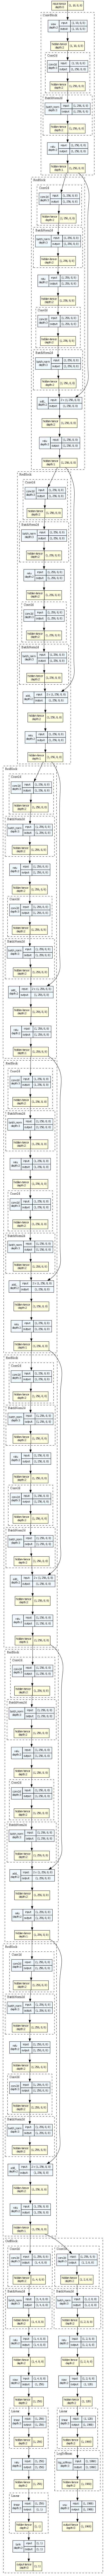

In [8]:
model_graph.visual_graph

# Loss function

In [9]:
class AlphaLoss(torch.nn.Module):
    def __init__(self):
        super(AlphaLoss, self).__init__()

    def forward(self, y_value, value, y_policy, policy):
        value_error = (value - y_value) ** 2
        policy_error = torch.sum((-policy * (1e-6 + y_policy.float()).float().log()), 1)
        total_error = value_error.squeeze() + policy_error
        return total_error.mean()

In [10]:
criterion = AlphaLoss()
print(criterion(torch.zeros(256,1),torch.zeros(256,1),torch.zeros(256,1968),torch.zeros(256,1968)))

tensor(0.)


# MCTS

In [11]:
class GameState(chess.Board):
    def __init__(self, fen=None):
        """
        初始化 GameState，默認使用標準起始局面。
        Args:
            fen (str, optional): 用於初始化的 FEN 字符串。
        """
        super().__init__(fen)

    def get_legal_actions(self):
        """
        獲取當前局面下的所有合法動作。
        Returns:
            list[chess.Move]: 一個包含所有合法行棋的列表。
        """
        return list(self.legal_moves)

    def copy_and_apply(self, action):
        """
        創建當前局面的副本，並應用指定的動作。
        Args:
            action (chess.Move): 要執行的動作。
        Returns:
            GameState: 更新後的新局面。
        """
        new_state = GameState(self.fen())
        new_state.push(action)
        return new_state

    def is_game_over(self):
        """
        判斷遊戲是否結束。
        Returns:
            bool: 如果遊戲結束則返回 True，否則 False。
        """
        return super().is_game_over()

    def get_result(self):
        """
        獲取當前局面的結果。
        Returns:
            float: 
                - 1.0: 白方勝利
                - -1.0: 黑方勝利
                - 0.0: 平局
        """
        if self.is_checkmate():
            return 1.0 if self.turn == chess.BLACK else -1.0
        elif self.is_stalemate() or self.is_insufficient_material():
            return 0.0
        return None  # 遊戲尚未結束

    def fen(self):
        """
        返回當前局面的 FEN 表示。
        Returns:
            str: FEN 字符串。
        """
        return super().fen()

In [12]:
class Node:
    def __init__(self, state):
        self.state = GameState(state.fen())           # 棋局狀態 (GameState)
        self.children = {}             # 子節點: {action: Node}
        self.visits = 0                # 節點被訪問次數 N(s)
        self.total_value = 0           # 總回報值 W(s)
        self.policy = None             # 策略分佈 P(s, a)

    def is_leaf(self):
        return len(self.children) == 0

    def expand(self, policy, prune_threshold=0.01):
        """
        擴展節點，基於策略 P(s, a) 和全域 index_to_action 進行剪枝。
        Args:
            policy (list): 動作機率陣列，index 對應到全域變數 index_to_action。
            prune_threshold (float): 剪枝閾值，低於該值的動作將被忽略。
        """
        global int_to_move  # 使用全域變數
        self.policy = {
            chess.Move.from_uci(int_to_move[i]): p for i, p in enumerate(policy) if p >= prune_threshold
        }
        for action in self.state.get_legal_actions():
            if action in self.policy.keys():
                new_state = self.state.copy_and_apply(action)
                self.children[action] = Node(new_state)

    def select_child(self, c_puct=1.0):
        """
        使用 PUCT 演算法選擇子節點。
        Args:
            c_puct (float): 探索與利用的權衡參數。
        Returns:
            (action, Node): 最佳動作及其對應子節點。
        """
        total_visits = sum(child.visits for child in self.children.values())
        best_score, best_action, best_node = -float('inf'), None, None

        for action, child in self.children.items():
            q = child.total_value / (child.visits + 1e-6)  # 避免除以 0
            u = c_puct * self.policy[action] * math.sqrt(total_visits) / (1 + child.visits)
            score = q + u
            if score > best_score:
                best_score, best_action, best_node = score, action, child

        return best_action, best_node

    def update(self, value):
        """
        更新節點的訪問次數和回報值。
        Args:
            value (float): 當前模擬的回傳值。
        """
        self.visits += 1
        self.total_value += value


    def best_action(self, temperature=1):
        """
        根據訪問次數 N(s, a) 選擇最佳行棋，支持隨機性。
        Args:
            temperature (float): 控制隨機性的參數，越接近 0 越貪婪。
        Returns:
            action: 根據隨機性或最大訪問次數選出的行棋。
        """
        visits = np.array([child.visits for child in self.children.values()])
        actions = list(self.children.keys())
        
        if temperature == 0:  # 純貪婪策略
            return actions[np.argmax(visits)]
        
        # 應用溫度進行概率調整
        probabilities = visits ** (1 / temperature)
        probabilities /= probabilities.sum()
        if actions == []:
            return None
        
        # 隨機抽樣
        return np.random.choice(actions, p=probabilities)

# with pruning
def mcts(root_state, model, n_simulations=800, prune_threshold=0.01,temperature=0):
    """
    使用 MCTS 搜索最佳行棋。
    Args:
        root_state (GameState): 當前棋局狀態。
        get_model_p_v (function): 用於獲取策略與價值的神經網路。
        n_simulations (int): 模擬次數。
        prune_threshold (float): 剪枝閾值。
    Returns:
        action: MCTS 選擇的最佳行棋。
    """
    root = Node(root_state)

    for _ in range(n_simulations):
        node = root
        path = []

        # Selection: 選擇最佳子節點直到葉節點
        while not node.is_leaf():
            action, node = node.select_child()
            path.append(node)

        # Expansion: 展開葉節點
        if not node.state.is_game_over():
            policy, value = model(torch.FloatTensor(np.array(canon_input_planes(node.state.fen()))).unsqueeze(0).to(device))
            policy = policy.squeeze(0).detach().cpu().numpy()
            value = value.squeeze(0).detach().cpu().numpy()
            if is_black_turn(node.state.fen()):
                policy = flip_policy(policy)
            node.expand(policy, prune_threshold)
        else:
            value = node.state.get_result()  # 終局結果

        # Backpropagation: 回傳模擬值
        for ancestor in reversed(path):
            ancestor.update(value)
            value = -value  # 反轉值對手視角

    # 根據訪問次數選擇最佳行棋
    return root.best_action(temperature)


In [13]:
class MCTS:
    def __init__(self, model, max_depth=15):
        """
        初始化 MCTS。
        Args:
            get_model_p_v (function): 獲取策略 (policy) 和價值 (value) 的神經網路函數。
            max_depth (int): 每次模擬的最大深度。
        """
        self.model = model
        self.max_depth = max_depth

    def search(self, root_state, n_simulations):
        """
        執行 MCTS 搜索。
        Args:
            root_state (GameState): 初始遊戲狀態。
            n_simulations (int): 模擬次數。
        Returns:
            Node: MCTS 搜索後的根節點。
        """
        root = Node(GameState(root_state.fen()) )

        for _ in range(n_simulations):
            node = root
            path = []
            depth = 0

            # Selection
            while not node.is_leaf() and depth < self.max_depth:
                action, node = node.select_child()
                path.append(node)
                depth += 1

            # Expansion
            if not node.state.is_game_over() and depth < self.max_depth:
                policy, value = model(torch.FloatTensor(np.array(canon_input_planes(node.state.fen()))).unsqueeze(0).to(device))
                policy = policy.squeeze(0).detach().cpu().numpy()
                value = value.squeeze(0).detach().cpu().numpy()
                if is_black_turn(node.state.fen()):
                    policy = flip_policy(policy)
                node.expand(policy)
            else:
                # 如果遊戲結束或達到模擬深度，直接返回當前值
                if node.state.is_game_over():
                    value = node.state.get_result()
                else:
                    policy, value = model(torch.FloatTensor(np.array(canon_input_planes(node.state.fen()))).unsqueeze(0).to(device))
                    # policy = policy.squeeze(0).detach().cpu().numpy()
                    value = value.squeeze(0).detach().cpu().numpy()
                    # if is_black_turn(node.state.fen()):
                    #     policy = flip_policy(policy)

            # Backpropagation
            for ancestor in reversed(path):
                ancestor.update(value)
                value = -value  # 翻轉值，因對手的收益是自己的損失

        return root

# Agent

In [14]:
class ChessAgent:
    def __init__(self, name, device, path=None):
        self.name = name
        self.device = device
        self.model = ChessNet().to(device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001,weight_decay=1e-4)
        self.criterion = AlphaLoss()

        self.memory = deque(maxlen=100000)
        self.batch_size = 512
        # self.train_size = 10000
        self.tau_decay_rate = 0.99
        if path:
          self.load_model(model_dir,path)
          self.model.to(device)
        else:
          pass

    def load_model(self, dir, filename):
        """Load a model from disk."""
        if os.path.exists(os.path.join(dir,filename)):
            # save_data = torch.load(os.path.join(dir,filename))
            save_data = torch.load(os.path.join(dir,filename),map_location=torch.device('cpu'))
            self.model.load_state_dict(save_data['model_state'])
            print(f"Model loaded from {filename}")
            return True
        return False

    def save_model(self,dir, filename):
        """Save a model to disk."""
        save_data = {
            'model_state': self.model.state_dict(),
        }
        path = os.path.join(dir,filename)
        torch.save(save_data, path)
        print(f"Model saved to {path}")

    def choose_action(self, board,max_depth = 15,n_simulations=1000,mode = 'tree'):
        """Choose action by probability."""
        if mode == 'mcts':
            n_move = int(board.fen().split(' ')[-1])
            # move = mcts(board,self.model,n_simulations=n_simulations,temperature=(1/n_move)*5)
            move = mcts(board,self.model,n_simulations=n_simulations,temperature = 1.0)
            if move is None:
                move = random.choice(list(board.legal_moves))
            return move.uci()
        elif mode == 'tree':
            tree = MCTS(self.model, max_depth=max_depth)
            root = tree.search(board, n_simulations=n_simulations)
            move = root.best_action(temperature = 1.0)
            if move is None:
                move = random.choice(list(board.legal_moves))
            return move.uci()

    def get_best_move(self, board):
        policy,value = self.model(torch.FloatTensor(np.array(canon_input_planes(board.fen()))).to(device))
        policy = policy.squeeze().cpu().detach().numpy()
        value = value.squeeze().cpu().detach().numpy()
        if is_black_turn(board.fen()):
            policy = flip_policy(policy)
        legal_moves = list(board.legal_moves)
        legal_moves_uci = [move.uci() for move in legal_moves]
        sorted_indices = np.argsort(policy)[::-1]
        for move_index in sorted_indices:
            move = int_to_move[move_index]
            if move in legal_moves_uci:
                return move
        return None
# agent = ChessAgent('test',device,'')

# Training

In [15]:
def dataloader(state_ary, policy_ary, value_ary,batch_size = 128):
  states = []
  policies = []
  values = []
  n = state_ary.shape[0]
  for i in range(n//batch_size):
    states.append(torch.tensor(state_ary[i*batch_size:(i+1)*batch_size],dtype=torch.float32).to(device))
    policies.append(torch.tensor(policy_ary[i*batch_size:(i+1)*batch_size],dtype=torch.float32).to(device))
    values.append(torch.tensor(value_ary[i*batch_size:(i+1)*batch_size],dtype=torch.float32).to(device))
  if n%batch_size != 0:
    states.append(torch.tensor(state_ary[n//batch_size*batch_size:],dtype=torch.float32).to(device))
    policies.append(torch.tensor(policy_ary[n//batch_size*batch_size:],dtype=torch.float32).to(device))
    values.append(torch.tensor(value_ary[n//batch_size*batch_size:],dtype=torch.float32).to(device))
  return states,policies,values

In [16]:
class CompetitiveChessTraining:
    def __init__(self,white_model_path=None,black_model_path=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.white_agent = ChessAgent("white", self.device,white_model_path)
        self.black_agent = ChessAgent("black", self.device,black_model_path)
        self.board = chess.Board()
        self.tau_decay_rate = 0.99
        self.labels = create_uci_labels()
        self.n_labels = int(len(labels))
        self.flipped_labels = flipped_uci_labels()
        self.unflipped_index = [labels.index(x) for x in flipped_labels]

        self.policy_dict = dict([(i,self.labels[i]) for i in range(len(self.labels))])

    def flip_policy(pol):
        """
        :param pol policy to flip:
        :return: the policy, flipped (for switching between black and white it seems)
        """
        return np.asarray([pol[ind] for ind in unflipped_index])

    def board_to_input(self, board):
        """Convert chess board to neural network input."""
        return torch.FloatTensor(np.array(canon_input_planes(board.fen())))

    def move_to_policy_index(self, move, turn):
        """Convert a chess move to policy index."""
        return self.labels.index(move.uci())

    def policy_index_to_move(self, index, board):
        """Convert policy index to chess move."""
        move = chess.Move.from_uci(self.policy_dict[index])
        return move if move in board.legal_moves else None

    def train_agents(self, memories):
      """Train agents on their memories."""
      for agent in [self.white_agent, self.black_agent]:
          if len(agent.memory) < agent.batch_size:
              continue
          agent.model.train()
          print('training')

        #   batch = random.sample(agent.memory, agent.batch_size)
          states, policies, values = zip(*agent.memory)
          states, policies, values = dataloader(states, policies, values,batch_size=agent.batch_size)
          print('test',len(values))

        #   states = torch.stack([self.board_to_input(s) for s in states]).to(self.device)
        #   policies = torch.FloatTensor(np.array(policies)).to(self.device)
        #   values = torch.FloatTensor(values).unsqueeze(1).to(self.device)

          predicted_policies, predicted_values = agent.model(states)

          loss = agent.criterion(predicted_values, values, predicted_policies, policies)

          agent.optimizer.zero_grad()
          loss.backward()
          agent.optimizer.step()


    def play_game(self):
      """Play a game between the two agents and collect training data."""
      self.board.reset()
      game_memory = []
      current_agent = self.white_agent

      while not self.board.is_game_over():
          state = self.board.copy()

          # Create the policy target (one-hot encoding of chosen move)
          policy = np.zeros(1968)
          move = current_agent.choose_action(self.board)
          move_index = all_moves2index_dict[move]
          policy[move_index] = 1

          self.board.push(chess.Move.from_uci(move))

          # The value target will be updated after the game ends
          game_memory.append((state, policy, current_agent))
          current_agent = self.black_agent if current_agent == self.white_agent else self.white_agent

      # Determine game outcome
      if self.board.is_checkmate():
          value = 1 if self.board.turn == chess.BLACK else -1
      else:  # Draw
          value = 0

      # Update memories with correct values
      white_memory = []
      black_memory = []
      for state, policy, agent in game_memory:
          if agent == self.white_agent:
              white_memory.append((state, policy, value))
          else:
              black_memory.append((state, policy, -value))
          value = -value  # Flip value for opponent

      # Add memories to respective agents
      self.white_agent.memory.extend(white_memory)
      self.black_agent.memory.extend(black_memory)

      # Train both agents
      if white_memory:
          self.train_agents(white_memory)
      if black_memory:
          self.train_agents(black_memory)

      return value
    
    def test(self):
       self.board.reset()
       import time
       current_agent = self.white_agent
       while not self.board.is_game_over():
          move = current_agent.choose_action(self.board)

          self.board.push(chess.Move.from_uci(move))
          display(self.board)
          time.sleep(1)
          current_agent = self.black_agent if current_agent == self.white_agent else self.white_agent
    
    def train_from_data(self,file_num=1):
      filenames = get_game_data_filenames(play_data_dir,play_data_filename_tmpl)
      print(filenames)
      epochs = 50
      agent = self.white_agent
      steps = 0
      batch_size = 512
      print(f'Training agent {agent.name}')
      while len(filenames)>0:
        states,policies,values=([],[],[])
        for _ in range(file_num):
          if not filenames:
            break
          filename = filenames.pop()
          print(f'load data from {filename}')
          state_ary, policy_ary, value_ary = load_data_from_file(filename)
          temp = dataloader(state_ary, policy_ary, value_ary,batch_size)
          states,policies,values = states+temp[0],policies+temp[1],values+temp[2]
          del temp, state_ary, policy_ary, value_ary
        print(f'num_data {len(values)}')
        for epoch in range(epochs):
          running_loss=0
          for state,policy,value in zip(states,policies,values):
            # print(state.size(),policy.size(),value.size())

            predicted_policies, predicted_values = agent.model(state)
            # print(predicted_policies.size(),predicted_values.size())

            loss = agent.criterion(predicted_values, value, predicted_policies, policy)

            agent.optimizer.zero_grad()
            loss.backward()
            agent.optimizer.step()
            running_loss += loss.item()
          if (epoch+1)%10==0:
              print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(values) :.4f}')
          steps+=1
        agent.save_model(model_dir,f'train_1201_2_{steps}.pt')


In [17]:
trainer = CompetitiveChessTraining(white_model_path='train_11_16_160.pt',black_model_path='train_11_16_160.pt')

Model loaded from train_11_16_160.pt
Model loaded from train_11_16_160.pt


In [21]:
trainer.train_from_data(file_num=1)

['game_data\\play_20241106-081021.294284.json', 'game_data\\play_20241106-081202.890002.json', 'game_data\\play_20241106-081400.892045.json', 'game_data\\play_20241106-081605.909969.json', 'game_data\\play_20241106-081747.197345.json', 'game_data\\play_20241106-081926.259108.json', 'game_data\\play_20241106-082122.258483.json', 'game_data\\play_20241106-082328.228559.json', 'game_data\\play_20241106-082512.481843.json', 'game_data\\play_20241106-082701.160691.json', 'game_data\\play_20241106-082901.117834.json', 'game_data\\play_20241106-083044.912710.json', 'game_data\\play_20241106-083219.636783.json', 'game_data\\play_20241106-083356.402751.json', 'game_data\\play_20241106-083538.826260.json', 'game_data\\play_20241106-083715.564172.json', 'game_data\\play_20241106-083852.912810.json', 'game_data\\play_20241106-084041.714106.json', 'game_data\\play_20241106-084227.841026.json', 'game_data\\play_20241106-084545.926364.json', 'game_data\\play_20241106-084803.067988.json']
Training age

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 2.00 GiB of which 0 bytes is free. Of the allocated memory 1.47 GiB is allocated by PyTorch, and 225.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

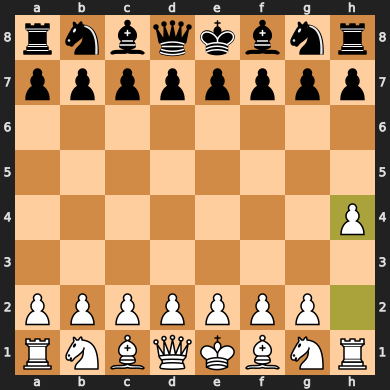

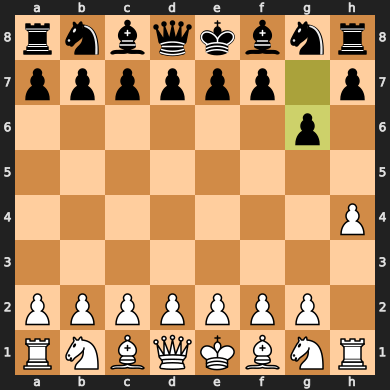

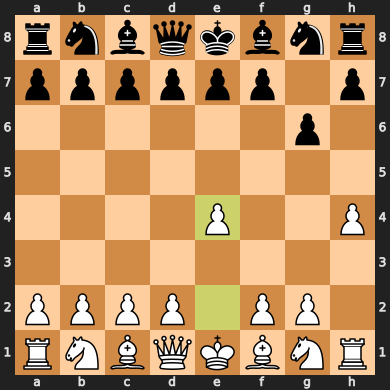

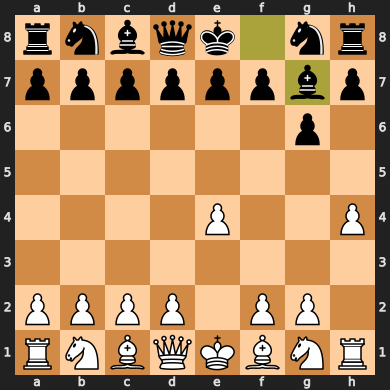

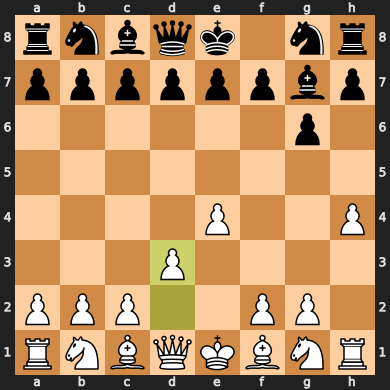

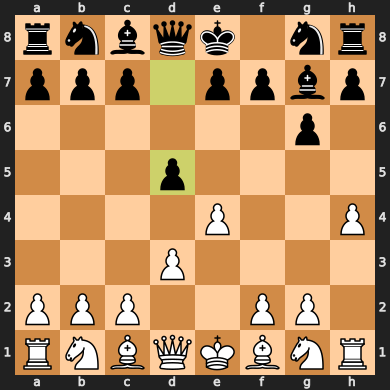

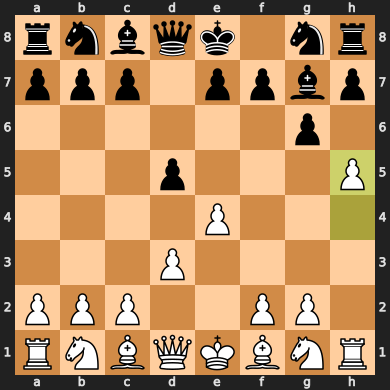

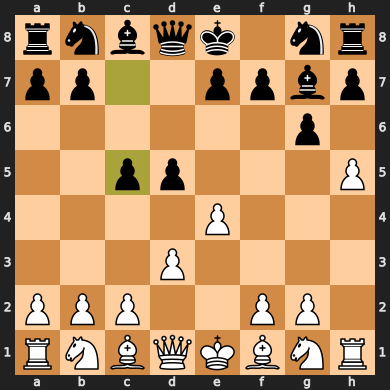

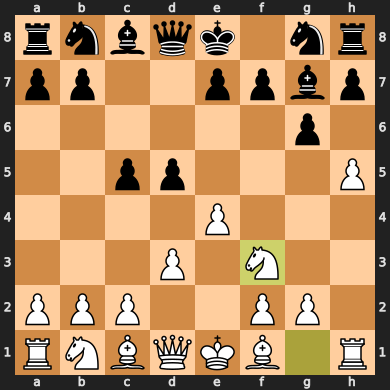

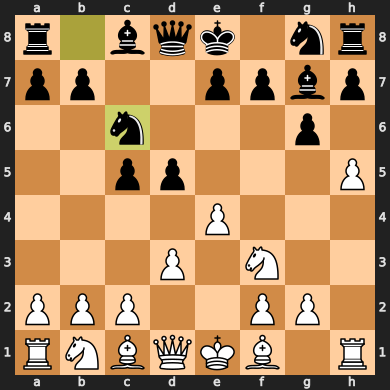

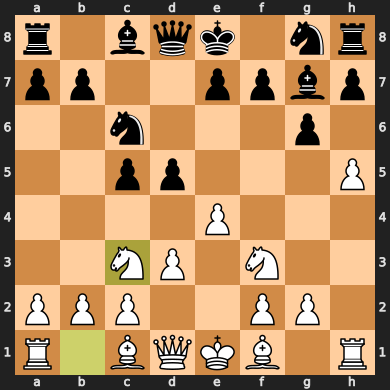

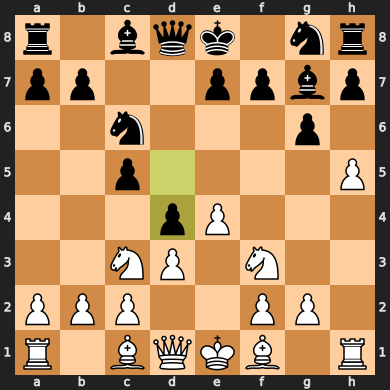

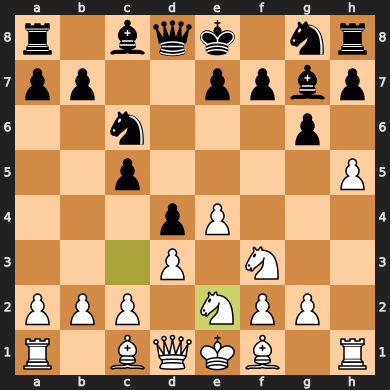

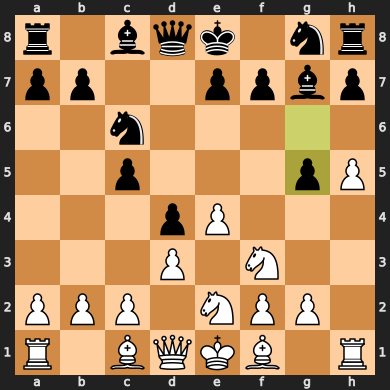

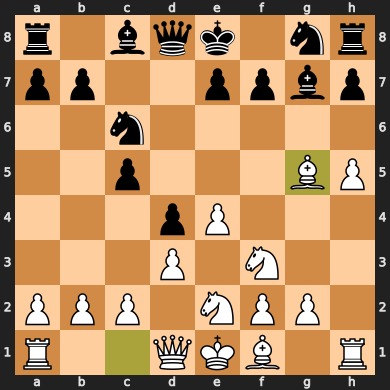

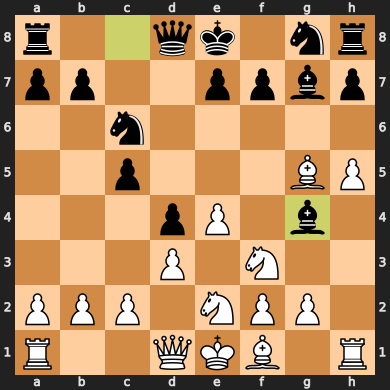

KeyboardInterrupt: 

In [22]:
trainer.test()

In [ ]:
trainer.white_agent.save_model(model_dir,f'train_by_games_test_white.pt')
# trainer.black_agent.save_model(model_dir,f'train_by_games_done_black.pt')

Model saved to /content/drive/MyDrive/Colab_Notebooks/rl_chess/models/train_by_games_test_white.pt


In [18]:
def train(trainer,num_games=10000):
    white_wins = 0
    black_wins = 0
    draws = 0

    for game in range(num_games):
        outcome = trainer.play_game()

        if outcome > 0:
            white_wins += 1
        elif outcome < 0:
            black_wins += 1
        else:
            draws += 1

        if (game+1) % 100 == 0:
            print(f"Game {game+1}")
            print(f"Stats - White: {white_wins}, Black: {black_wins}, Draws: {draws}")
            print("------------------------")
            if (game+1)%1000 == 0:
                trainer.white_agent.save_model(model_dir,f'train_by_games{game+1}_white.pt')
                trainer.black_agent.save_model(model_dir,f'train_by_games{game+1}_black.pt')

In [19]:
game = 0
trainer = CompetitiveChessTraining(white_model_path='train_1111_30.pt',black_model_path='train_1111_30.pt')
# trainer = CompetitiveChessTraining()
train(trainer)

Model loaded from train_1111_30.pt
Model loaded from train_1111_30.pt


KeyboardInterrupt: 

# Evaluate

In [14]:
model = trainer.white_agent.model
model.eval()
def evaluate(model):
    filename = get_game_data_filenames(play_data_dir,play_data_filename_tmpl)[-1]
    print(filename)
    states,policies,values=([],[],[])
    print(f'load data from {filename}')
    state_ary, policy_ary, value_ary = load_data_from_file(filename)
    N = len(value_ary)
    temp = dataloader(state_ary, policy_ary, value_ary,256)
    states,policies,values = states+temp[0],policies+temp[1],values+temp[2]
    del temp, state_ary, policy_ary, value_ary
    print(f'num of data: {len(values)}')
    running_loss=0
    acc = 0
    for state,policy,value in zip(states,policies,values):
        predicted_policies, predicted_values = model(state)
        print(torch.argmax(predicted_policies),1)
evaluate(model)

NameError: name 'trainer' is not defined

# Play with human

In [26]:
class ChessGame:
    def __init__(self,trainer, agent=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.board = chess.Board()
        self.agent = agent
        self.trainer = trainer
        # Assuming this exists from previous code

    def display_board(self):
        """Display the current board state."""
        return self.board

    def get_user_move(self):
        """Get a move from the user."""
        while True:
            try:
                move_uci = input("Enter your move (in UCI format, e.g., 'e2e4'): ")
                if move_uci == 'stop':
                    return 'stop'
                move = chess.Move.from_uci(move_uci)
                if move in self.board.legal_moves:
                    return move
                else:
                    print("Illegal move. Try again.")
            except ValueError:
                print("Invalid input. Please use UCI format (e.g., 'e2e4')")

    def get_model_move(self,rule='mcts'): # return str(uci move)
        """Get a move from the AI model."""
        if rule == 'only_by_model':
          return self.agent.choose_action(self.board)
        elif rule == 'minimax':
          return self.minimax.get_best_move(self.board)
        elif rule == 'mcts':
          move = mcts(self.board,self.agent.model,n_simulations=500)
          return move.uci()

    def play_game(self, human_color=chess.WHITE):
        """Play a game between human and AI."""
        import time
        AI_name = 'b' if human_color else 'w'
        # self.tree = MCTS(AI_name,self.agent.model,self.board)
        # self.minimax = Alphabeta(1,self.agent.model,not(human_color))
        while not self.board.is_game_over():
            display(self.display_board())
            time.sleep(1)
            is_human_turn = (self.board.turn == human_color)

            if is_human_turn:
                move = self.get_user_move()
                if move == 'stop':
                    break

            else:
                print("AI is thinking...")
                move = chess.Move.from_uci(self.get_model_move())
                print(f"AI plays: {move.uci()}")

            self.board.push(move)

        if move == 'stop':
            print('game stop')
            return 0
        # Game over
        display(self.display_board())
        result = self.board.outcome()
        if result.winner is None:
            print("Game drawn!")
        else:
            winner = "White" if result.winner else "Black"
            print(f"{winner} wins!")

Model loaded from train_11_16_160.pt
Model loaded from train_11_16_160.pt


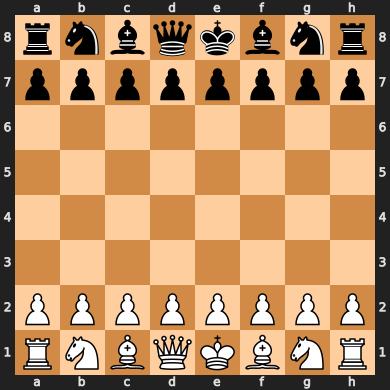

AI is thinking...


In [ ]:
trainer = CompetitiveChessTraining(white_model_path='train_11_16_160.pt',black_model_path='train_11_16_160.pt')
game = ChessGame(trainer,agent=trainer.white_agent)

while True:
    color = input("Choose your color (white/black): ").lower()
    if color in ['white', 'black']:
        human_color = chess.WHITE if color == 'white' else chess.BLACK
        game.play_game(human_color=human_color)

    play_again = input("Play again? (yes/no): ").lower()
    if play_again != 'yes':
        break
    else:
      game.board.reset()

# References:

https://deepanshut041.github.io/Reinforcement-Learning/notes/00_Introduction_to_rl/

https://github.com/zjeffer/chess-deep-rl

https://github.com/Zeta36/chess-alpha-zero/tree/master

https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ

https://arxiv.org/abs/1712.01815

https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning

https://www.ficsgames.org/download.html
